## **LuSEE CST beam read notebook**
Date: 27 Mar 2022 
Author: Bang Nhan (NRAO)
***
__Objectives__

* Use this script to read out pickled beam data object BeamObj provided by Bang Nhan from NRAO using CST. 

***
__Tests__
1. [ ] 

***
__References__

[hyperlink]()

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
# Standard modules:
import os
import sys
import numpy as np
import pdb
import pickle as pk
import h5py
import matplotlib.pyplot as plt  
# Set white background
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

# -----
def data_dict_hdf5_read(fname_hdf5,msg_bool=True,
                        file_mode = 'r',redo_save = None):
    """
    This function will read from HDF5 and pass as a dictionary (same
    format as the input). The main purpose of this function is to save
    and load larger data during the DAQ and reduction processes. This
    is a generalized version of both former function
    map_dict_hdf5_save() and sat_online_dict_hdf5_save().    

    Parameters
    ----------
    fname_hdf5 : str
    msg_bool : bool
        True to display the name of the subgroups being created
    file_mode : str
        'r' for read 

    Returns
    -------
    data_dict_out : dict
        Return the data_dict_out if file_mode = 'r' to read from the
        HDF5 file

    """
       
    print("Loading HDF5 into dictionary...")        
    data_dict_out = {}
    with h5py.File(fname_hdf5, file_mode) as f_h5:
        subgrp_keys = list(f_h5.keys()) # in Unicode string u'string' for the HDF5 group path!!!
        for k0 in range(len(subgrp_keys)):
            subgrp_keys_k0 = subgrp_keys[k0]
            # Update the existing dictionary to proper keys and values:
            data_dict_out.update({str(subgrp_keys_k0):{}})
            grp_path = subgrp_keys_k0
            
            data_dict_out = h5_subgrp_read(data_dict_out,f_h5,grp_path,subgrp_keys_k0)
                
    print("Done loading HDF5 into dictionary")
    return data_dict_out       

# -----
def h5_subgrp_read(map_dict_in,f_h5,grp_path,grp_keys):                   
    """
    Recursive loop to convert HDF5 groups and subgroups into nested
    dictionaries for the map_dict sotring the reduced map data.

    Parameters
    ----------
    map_dict_in : dict
    f_h5 : object
    grp_path : unicode str
    grp_keys : unicode str

    Returns
    -------
    map_dict_in : dict

    """
    f_h5_grp = f_h5[grp_path]
    
    # Check if there exist attrs in the HDF5 subgroups:
    subgrp_attrs = list(f_h5_grp.attrs.keys())
    
    # Check the existing keys of the HDF5 subgroups:
    subgrp_keys = list(f_h5_grp.keys())

    # Check if there is attributes in the subgroups:
    if len(subgrp_attrs) > 0:
        for k0 in range(len(subgrp_attrs)):
            data_k0 = f_h5_grp.attrs[subgrp_attrs[k0]]
            dict_keys = str(grp_path).split('/') # convert uint8 to str, and split at '/'

            if len(dict_keys) == 1: #grp_keys == grp_path: 
                map_dict_in[dict_keys[0]].update({str(subgrp_attrs[k0]):data_k0})
            else: #(Different if no long on the top level group)
                if len(dict_keys) == 2:
                    map_dict_in[dict_keys[0]].update({dict_keys[1]:{str(subgrp_attrs[k0]):data_k0}})

    # Check if there is keys in the subgroups:                    
    if len(subgrp_keys) > 0:
        for k0 in range(len(subgrp_keys)):
            subgrp_keys_k0 = str(subgrp_keys[k0])  # need to convert the unicode string string
            subgrp_path0 = '%s/%s'%(grp_path,subgrp_keys_k0)                      
            dict_keys0 = str(subgrp_path0).split('/')
            
            if type(f_h5[subgrp_path0]) is h5py.Dataset: # Is a dataset
                check = dict_keys0.count(dict_keys0[0]) == len(dict_keys0)
                if check: # Duplicated group name, commonly this indicate it's a data set
                    dict_keys0 = dict_keys0[0:1]

                dset_k0 = f_h5[subgrp_path0][()]# Store the corresponding HDF5 dataset as dset_k0

                # Loop through the dict_keys and update the dictionary
                # instead, so no need to check whether len(dict_keys)
                # is 2 or 3, or 4.
                for k in range(len(dict_keys0)):
                    if k == 0: # Rename dict_k as the top layer of the dictionary
                        if len(dict_keys0) == 1:
                            map_dict_in[dict_keys0[k]] = dset_k0
                        else:
                            dict_k = map_dict_in[dict_keys0[k]]
                        
                    elif k == len(dict_keys0)-1: # Store the dataset to the sub-dictionary
                        dict_k.update({dict_keys0[k]:dset_k0})
                    else: # Rename dict_k as the subsequent su-dictionary, before hitting the dataset dict_keys0
                        dict_k = dict_k[dict_keys0[k]]
                        
            elif type(f_h5[subgrp_path0]) is h5py.Group: # Is a group
                # Loop through the dict_keys and update the dictionary
                # instead, so no need to check whether len(dict_keys)
                # is 2 or 3, or 4. (Note: This dict_keys0 is one
                # element shorter than the one inside the dataset
                # condition due to the second time running
                # h5_subgrp_read() below.)
                for k in range(len(dict_keys0)):
                    if k == 0:
                        dict_k = map_dict_in[dict_keys0[k]]
                    elif k == len(dict_keys0)-1:
                        # If the new subgrp_keys_k0 not in the keys of the
                        # dictionary, create it as an empty dict:
                        if subgrp_keys_k0 not in list(dict_k.keys()):                        
                            dict_k.update({subgrp_keys_k0:{}})
                    else:
                        dict_k = dict_k[dict_keys0[k]]
                # Enter the function another time:
                map_dict_in = h5_subgrp_read(map_dict_in,f_h5,subgrp_path0,
                                             subgrp_keys_k0)               
    return map_dict_in


In [44]:
# Load BeamObj from pickle (deserialize)
# use dir() to look at the attributes of BeamObj & BeamObj.beam_obj_dict[a_num]

# Set cst_model_dir to where you will store the data a*_BeamObj.pk locally
cst_model_dir = 'local/data/directory/'
cst_model_dir = '/export/data/low_freq_lab/research/projects/dapper/data/model/cst_model/data_export/lander/stacer/para_sweep_export/lusee_dipole_test_soil0_v000/'

a_num_tag = ['a7171852'] # A# tag for each CST simulation run. See sim_para_output/a*_sim_parameters.txt for CST simulation parameter list
# Only one A# for the dipole test at the moment (as of 27 Mar 2022)

for a_num in a_num_tag:
    
    beam_object_fname_h5 = cst_model_dir + f'{a_num}/{a_num}_BeamObjSave_cst_bnhan.h5'
    BeamObjSave = data_dict_hdf5_read(beam_object_fname_h5,file_mode='r',
                                      redo_save=False,msg_bool=False)

    # Check number of ports: If = 4, then touchstone format, S4P. Else, single port s11
    
    n_port = len(BeamObjSave['port_in_str'])
    port_num = [x.decode('UTF-8') for x in BeamObjSave['port_in_str']]
    for n in range(n_port):
        if n_port == 1: # Single port
            # ---- Read S11        
            spara_dict = BeamObjSave[f'port{port_num[n]}']['spara_dict']
            spara_type = 's11'
            # For single port: spara_dict.keys() = ['freq_mhz', 'spara_mag_linear', 'spara_phase_deg']
            spara_freq = spara_dict[spara_type]['freq_mhz'] # 1001 points
            spara_dat = spara_dict[spara_type]['spara_mag_linear']*np.exp(1j*spara_dict[spara_type]['spara_phase_deg'])
        elif n_port == 4:
            print("Need to read S4P format")
    
        if n == 0: # Only need to read the freq once
            # ---- Farfield & efficiency freq [same length as the number farfield monitors]:
            freq_mhz = BeamObjSave[f'port{port_num[n]}']['freq_khz']*1e-6
    
        # ---- Read Efficiecny curves
        eff_dict = BeamObjSave[f'port{port_num[n]}']['eff_dict']
        rad_eff = eff_dict['rad']
        tot_eff = eff_dict['tot']
    
        # ---- Read Farfield
        ff_dict = BeamObjSave[f'port{port_num[n]}']['beam_ff_dict']
        freq_keys = np.sort(list(ff_dict.keys()))
        # ff_dict.keys() = ['freq_khz':{'FFabs', 'FFphi':{'mag','phase'},'FFtheta':{'mag',phase'}, 'axial_ratio','phi','theta'}]
        # Read Theta & phi once for all freq:    
        ff_theta = ff_dict[freq_keys[0]]['theta'] # 2D array [len(tehta) x len(phi)]
        ff_phi = ff_dict[freq_keys[0]]['phi']  # 2D array [len(tehta) x len(phi)]
    
    
        # Need to read these for different freq:    
        # E.g., saving them as array: 
        if n == 0: # define arrays:
            Efield_abs = np.zeros([n_port,len(freq_keys),np.shape(ff_theta)[0],np.shape(ff_phi)[1]])
            Efield_theta = 0*Efield_abs
            Efield_phi = 0*Efield_abs
            
        for k in range(len(freq_keys)):
            Efield_abs[n,k,:,:] = ff_dict[freq_keys[k]]['FFabs']
            Efield_theta[n,k,:,:] = ff_dict[freq_keys[k]]['FFtheta']['mag']*np.exp(1j*np.radians(ff_dict[freq_keys[k]]['FFtheta']['phase']))
            Efield_phi[n,k,:,:] = ff_dict[freq_keys[k]]['FFphi']['mag']*np.exp(1j*np.radians(ff_dict[freq_keys[k]]['FFphi']['phase']))
    
    

Loading HDF5 into dictionary...
Done loading HDF5 into dictionary


/users/bnhan/anaconda2/envs/pipe_sim_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
/users/bnhan/anaconda2/envs/pipe_sim_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:60: ComplexWarning: Casting complex values to real discards the imaginary part


## Plot S11

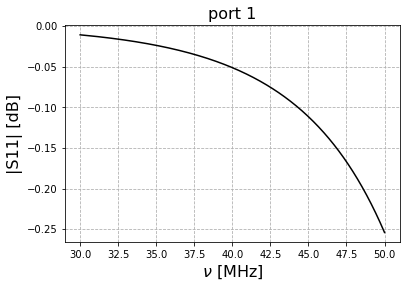

In [57]:
fig = plt.plot(figsize=(10,7))
port = '1'
plt.plot(spara_freq,20*np.log10(np.abs(spara_dat)),'k-')
plt.title(f'port {port}', fontsize=16)
plt.xlabel(r'$\nu$ [MHz]', fontsize=16)
plt.ylabel('|S11| [dB]', fontsize=16)
#plt.legend(bbox_to_anchor=(1,1),fontsize=16)
plt.grid(ls='--')

## Plot Efficiency Curves

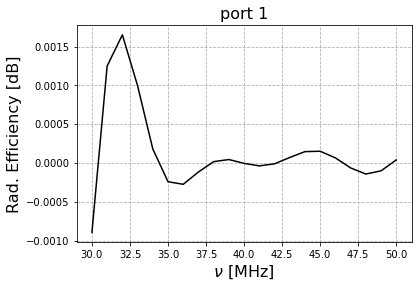

In [58]:
fig = plt.plot(figsize=(10,7))
port = '1'
plt.plot(freq_mhz, 10*np.log10(rad_eff['eff_linear']),'k-')
plt.title(f'port {port}', fontsize=16)
plt.xlabel(r'$\nu$ [MHz]', fontsize=16)
plt.ylabel('Rad. Efficiency [dB]', fontsize=16)
#plt.legend(bbox_to_anchor=(1,1),fontsize=16)
plt.grid(ls='--')

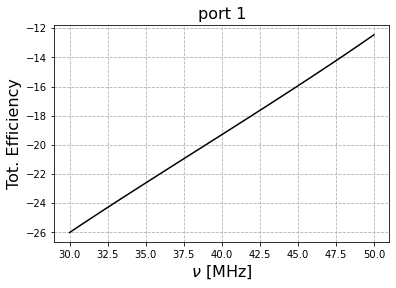

In [55]:
fig = plt.plot(figsize=(10,7))
port = '1'
plt.plot(freq_mhz, 10*np.log10(tot_eff['eff_linear']),'k-')
plt.title(f'port {port}', fontsize=16)
plt.xlabel(r'$\nu$ [MHz]', fontsize=16)
plt.ylabel('Tot. Efficiency [dB]', fontsize=16)
#plt.legend(bbox_to_anchor=(1,1),fontsize=16)
plt.grid(ls='--')

## Plot E-field beam cuts on E & H planes

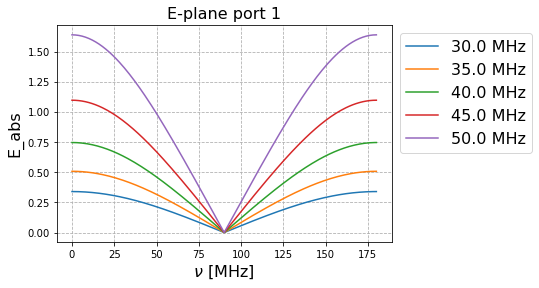

In [41]:
fig = plt.plot(figsize=(10,7))
port = '1'
for k in range(len(freq_mhz)):
    if k%5 == 0:
        plt.plot(Efield_abs[0,k,:,0], label=f'{freq_mhz[k]} MHz')
plt.title(f'E-plane port {port}', fontsize=16)
plt.xlabel(r'$\nu$ [MHz]', fontsize=16)
plt.ylabel('E_abs [V/m]', fontsize=16)
plt.legend(bbox_to_anchor=(1,1),fontsize=16)
plt.grid(ls='--')

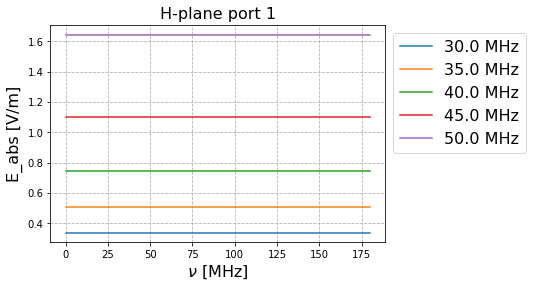

In [59]:
fig = plt.plot(figsize=(10,7))
for k in range(len(freq_mhz)):
    if k%5 == 0:
        plt.plot(Efield_abs[0,k,:,90], label=f'{freq_mhz[k]} MHz')
plt.title(f'H-plane port {port}', fontsize=16)
plt.xlabel(r'$\nu$ [MHz]', fontsize=16)
plt.ylabel('E_abs [V/m]', fontsize=16)
plt.legend(bbox_to_anchor=(1,1),fontsize=16)
plt.grid(ls='--')